In [8]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image


In [9]:

# Read and shuffle the data
data = pd.read_csv('mnist_data.csv')
data = data.sample(frac=1, random_state=42).reset_index(drop=True)
test_size = 6000
train_size = 6000

test_data = data.iloc[:test_size]
train_data = data.iloc[test_size:test_size + train_size]

def preprocess_data(data):
    labels = data.iloc[:, 0].values
    pixels = data.iloc[:, 1:].values
    images = pixels.reshape(-1, 28, 28)
    return labels, images

train_labels, train_images = preprocess_data(train_data)
test_labels, test_images = preprocess_data(test_data)



In [10]:
def create_balanced_label_pairs(labels, images):
    pairs = []
    pair_labels = []
    unique_labels = np.unique(labels)
    label_indices = {label: np.where(labels == label)[0] for label in unique_labels}
    for idx, label in enumerate(labels):
        img1 = images[idx]
        positive_indices = label_indices[label]
        positive_indices = positive_indices[positive_indices != idx]
        positive_samples = np.random.choice(positive_indices, size=9, replace=len(positive_indices) < 9)
        for target_idx in positive_samples:
            img2 = images[target_idx]
            pairs.append((img1, img2))
            pair_labels.append(1) 
        for target_label in unique_labels:
            if target_label != label:
                target_indices = label_indices[target_label]
                target_idx = np.random.choice(target_indices)
                img2 = images[target_idx]
                pairs.append((img1, img2))
                pair_labels.append(0) 
    return pairs, pair_labels
train_pairs, train_pair_labels = create_balanced_label_pairs(train_labels, train_images)
test_pairs, test_pair_labels = create_balanced_label_pairs(test_labels, test_images)

print("训练集对数:", len(train_pairs))
print("测试集对数:", len(test_pairs))



训练集对数: 108000
测试集对数: 108000


In [11]:
class PairDataset(torch.utils.data.Dataset):
    def __init__(self, pairs, labels):
        self.pairs = pairs
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        vec1, vec2 = self.pairs[idx]
        label = self.labels[idx]
        pair = np.stack([vec1, vec2], axis=0)
        pair = torch.tensor(pair, dtype=torch.float32)
        label = torch.tensor(label, dtype=torch.long)
        return pair, label
train_dataset = PairDataset(train_pairs, train_pair_labels)
test_dataset = PairDataset(test_pairs, test_pair_labels)


In [12]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        # 卷积部分
        self.conv_layers = nn.Sequential(
            nn.Conv2d(2, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32), 
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        # 全连接部分
        self.fc_layers = nn.Sequential(
            nn.Linear(128 * 3 * 3, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, 2), 
        )

    def forward(self, x):
        x = self.conv_layers(x) 
        x = x.view(x.size(0), -1) 
        x = self.fc_layers(x) 
        return x




In [26]:
# 剪枝函数
@torch.no_grad()
def prune_conv_layer(model, test_loader, device, prune_rate=0.1):
    model.eval()

    activations = []
    def hook_fn(module, input, output):
        activations.append(output.detach())
    hook = model.conv_layers[-4].register_forward_hook(hook_fn)
    for images, _ in test_loader:
        images = images.to(device)
        _ = model(images)
    hook.remove()
    activations = torch.cat(activations, dim=0)
    mean_activations = torch.abs(activations.mean(dim=(0, 2, 3)))
    _, indices = torch.sort(mean_activations)

    _, indices = torch.sort(mean_activations)
    prune_count = int(len(indices) * prune_rate)
    prune_indices = indices[:prune_count]

    last_conv_layer = model.conv_layers[-4]
    weight = last_conv_layer.weight.data
    weight[prune_indices] = 0 

    print(f'Pruned {prune_count} channels out of {len(indices)}')
    return model

@torch.no_grad()
def evaluate_model(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0

    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Accuracy: {accuracy:.2f}%')
    return accuracy

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CNN().to(device)

# 这边采用了二分类常用的交叉熵损失函数和Adam优化器
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# 训练模型
epochs = 10
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f'Epoch {epoch + 1}/{epochs}, Loss: {running_loss / len(train_loader):.4f}')





Epoch 1/10, Loss: 0.2812
Epoch 2/10, Loss: 0.1419
Epoch 3/10, Loss: 0.1012
Epoch 4/10, Loss: 0.0736
Epoch 5/10, Loss: 0.0595
Epoch 6/10, Loss: 0.0475
Epoch 7/10, Loss: 0.0388
Epoch 8/10, Loss: 0.0337
Epoch 9/10, Loss: 0.0285
Epoch 10/10, Loss: 0.0243


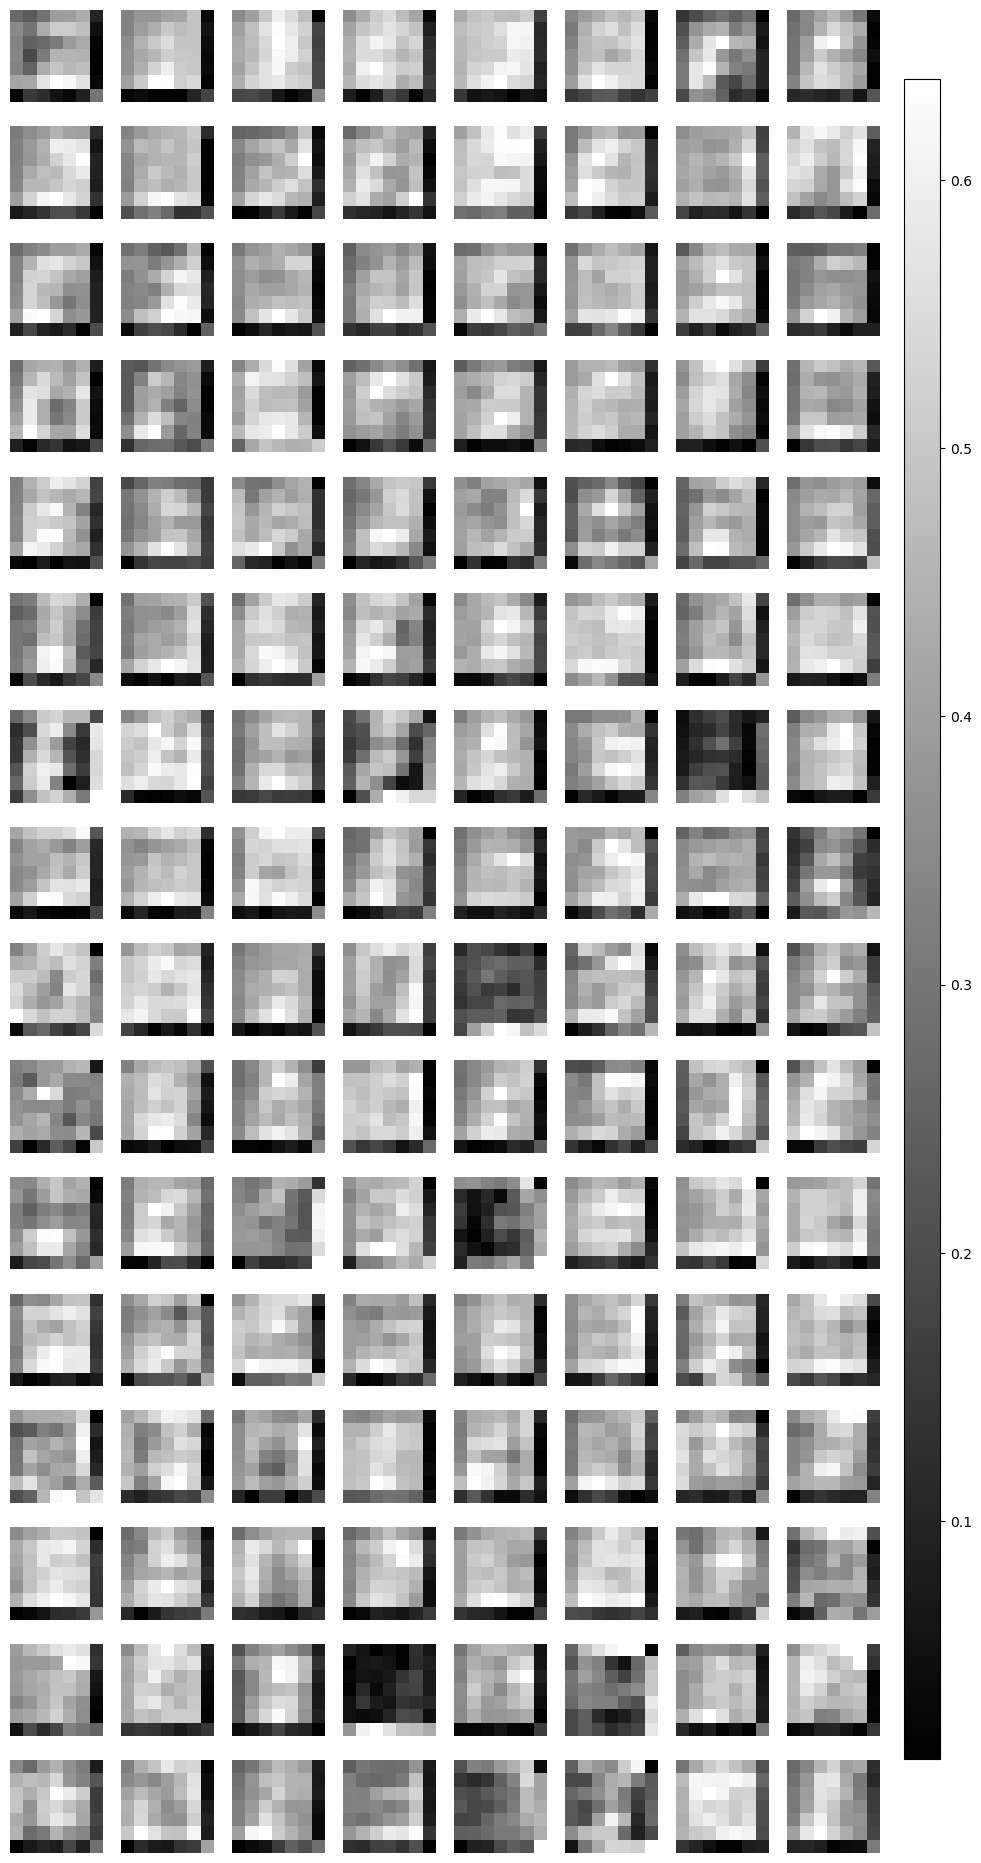

In [31]:
@torch.no_grad()
def visualize_conv_output(model, test_loader, device):
    model.eval()
    activations = []

    def hook_fn(module, input, output):
        activations.append(output.detach())

    hook = model.conv_layers[-4].register_forward_hook(hook_fn)

    for images, _ in test_loader:
        images = images.to(device)
        _ = model(images)
    hook.remove()
    activations = torch.cat(activations, dim=0).mean(dim=0).abs().cpu()
    activations = activations / activations.max()
    num_features = activations.size(0)
    fig, axes = plt.subplots(16, 8, figsize=(12, 24)) 
    for i, ax in enumerate(axes.flat):
        if i < num_features:
            im = ax.imshow(activations[i], cmap='gray')
            ax.axis('off') 
        else:
            ax.axis('off')

    fig.subplots_adjust(right=0.85)
    cbar_ax = fig.add_axes([0.87, 0.15, 0.03, 0.7]) 
    plt.colorbar(im, cax=cbar_ax)
    plt.show()

visualize_conv_output(model, test_loader, device)

In [ ]:
prune_rates = np.arange(0.0, 1.0, 0.05)
accuracies = []

for prune_rate in prune_rates:
    pruned_model = prune_conv_layer(model, test_loader, device, prune_rate=prune_rate)
    accuracy = evaluate_model(pruned_model, test_loader, device)
    accuracies.append(accuracy)

plt.figure(figsize=(10, 6))
sns.lineplot(x=prune_rates, y=accuracies, marker='o')
plt.xlabel('Prune Rate')
plt.ylabel('Accuracy (%)')
plt.title('Pruning Rate vs Accuracy')
plt.grid(True)
plt.show()

In [ ]:
plt.figure(figsize=(10, 6))
sns.lineplot(x=prune_rates, y=accuracies, marker='o')
plt.xlabel('Prune Rate')
plt.ylabel('Accuracy (%)')
plt.title('Pruning Rate vs Accuracy')
plt.grid(True)
plt.show()